In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

In [2]:
from IPython.display import Audio

import librosa
import librosa.display

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,matthews_corrcoef
from sklearn.metrics import cohen_kappa_score,roc_auc_score,confusion_matrix,classification_report

In [4]:
import tensorflow as tf
from keras.utils import to_categorical
from tensorflow.keras.layers import concatenate
from tensorflow.keras.models import Sequential, Model, load_model

from tensorflow.keras.layers import Conv1D, Conv2D, SeparableConv1D, MaxPooling1D, MaxPooling2D
from tensorflow.keras.layers import Input, add, Flatten, Dense, BatchNormalization, Dropout, LSTM, GRU
from tensorflow.keras.layers import GlobalMaxPooling1D, GlobalMaxPooling2D, Activation, LeakyReLU, ReLU


from tensorflow.keras import regularizers
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

## Load Dataset

In [5]:
audio_data = '../Lung/Lungs_Dataset/Respiratory_Sound_Database/audio_and_txt_files/'

In [6]:
diagnosis_df = pd.read_csv('modified_patient_diagnosis.csv')

In [7]:
diagnosis_df

,pid,disease
0,101,Acute
1,102,Healthy
2,103,Chronic
3,104,Chronic
4,105,Acute
...,...,...
127,228,Healthy
128,229,Chronic
129,230,Healthy
130,231,Healthy


In [8]:
diagnosis_df['disease'].unique()

array(['Acute', 'Healthy', 'Chronic'], dtype=object)

(array([0, 1, 2]),
 [Text(0, 0, 'Acute'), Text(1, 0, 'Healthy'), Text(2, 0, 'Chronic')])

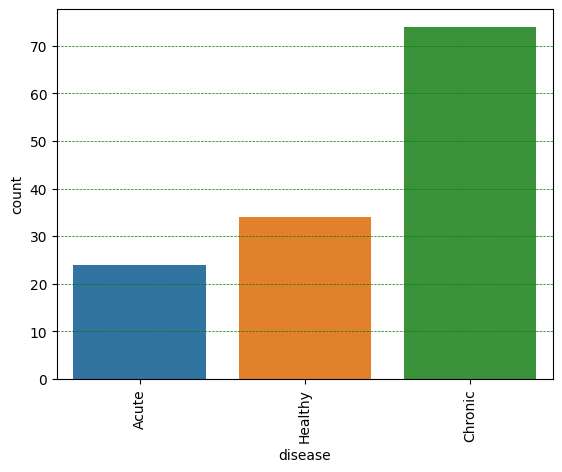

In [9]:
sns.countplot(data=diagnosis_df, x='disease')
plt.grid(axis = 'y',color = 'green', linestyle = '--', linewidth = 0.5)
plt.xticks(rotation=90)

In [10]:
diagnosis_df['disease'].value_counts()

Chronic    74
Healthy    34
Acute      24
Name: disease, dtype: int64

In [11]:
def add_noise(data,x):
    noise = np.random.randn(len(data))
    data_noise = data + x * noise
    return data_noise

def shift(data,x):
    return np.roll(data, x)

def stretch(data, rate):
    data = librosa.effects.time_stretch(y=data, rate=rate)
    return data

def pitch_shift (data , rate):
    data = librosa.effects.pitch_shift(data, sr=220250, n_steps=rate)
    return data

In [12]:
def show_audio(audio_path):
    y, sr = librosa.load(audio_path)
    y_noise = add_noise(y , 0.0008)
    y_shift = shift(y,3200)
    y_stretch_1 = stretch(y, 1.2)
    y_stretch_2 = stretch(y, 0.8)
    y_pitch_shift = pitch_shift(y, 3)
    
    plt.figure(figsize=(20, 8))
    
    plt.subplot(3,2,1)
    librosa.display.waveshow(y, sr=sr)
    plt.title('orginal')

    plt.subplot(3,2,2)
    librosa.display.waveshow(y_noise, sr=sr)
    plt.title('noise')

    plt.subplot(3,2,3)
    librosa.display.waveshow(y_shift, sr=sr)
    plt.title('shift')
    
    plt.subplot(3,2,4)
    librosa.display.waveshow(y_stretch_1, sr=sr)
    plt.title('stretch 1')
    
    plt.subplot(3,2,5)
    librosa.display.waveshow(y_stretch_2, sr=sr)
    plt.title('stretch 2')
    
    plt.subplot(3,2,6)
    librosa.display.waveshow(y_pitch_shift, sr=sr)
    plt.title('pitch shift')

    plt.tight_layout()

In [13]:
def show_audio_features(audio_path):
    y, sr = librosa.load(audio_path)
    y_noise = add_noise(y , 0.0008)
    y_shift = shift(y,3200)
    y_stretch_1 = stretch(y, 1.2)
    y_stretch_2 = stretch(y, 0.8)
    y_pitch_shift = pitch_shift(y, 3)
    
    y = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=50)
    y_noise = librosa.feature.mfcc(y=y_noise, sr=sr, n_mfcc=50)
    y_shift = librosa.feature.mfcc(y=y_shift, sr=sr, n_mfcc=50)
    y_stretch_1 = librosa.feature.mfcc(y=y_stretch_1, sr=sr, n_mfcc=50)
    y_stretch_2 = librosa.feature.mfcc(y=y_stretch_2, sr=sr, n_mfcc=50)
    y_pitch_shift = librosa.feature.mfcc(y=y_pitch_shift, sr=sr, n_mfcc=50)
    
    plt.figure(figsize=(20, 8))
    
    plt.subplot(3,2,1)
    librosa.display.specshow(librosa.power_to_db(y,ref=np.max),
                             y_axis='mel',
                             fmax=8000,
                             x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title('orginal')

    plt.subplot(3,2,2)
    librosa.display.specshow(librosa.power_to_db(y_noise,ref=np.max),
                             y_axis='mel',
                             fmax=8000,
                             x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title('noise')

    plt.subplot(3,2,3)
    librosa.display.specshow(librosa.power_to_db(y_shift,ref=np.max),
                             y_axis='mel',
                             fmax=8000,
                             x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title('shift')
    
    plt.subplot(3,2,4)
    librosa.display.specshow(librosa.power_to_db(y_stretch_1,ref=np.max),
                             y_axis='mel',
                             fmax=8000,
                             x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title('stretch 1')
    
    plt.subplot(3,2,5)
    librosa.display.specshow(librosa.power_to_db(y_stretch_2,ref=np.max),
                             y_axis='mel',
                             fmax=8000,
                             x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title('stretch 2')
    
    plt.subplot(3,2,6)
    librosa.display.specshow(librosa.power_to_db(y_pitch_shift,ref=np.max),
                             y_axis='mel',
                             fmax=8000,
                             x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title('pitch shift')
    
    

    plt.tight_layout()

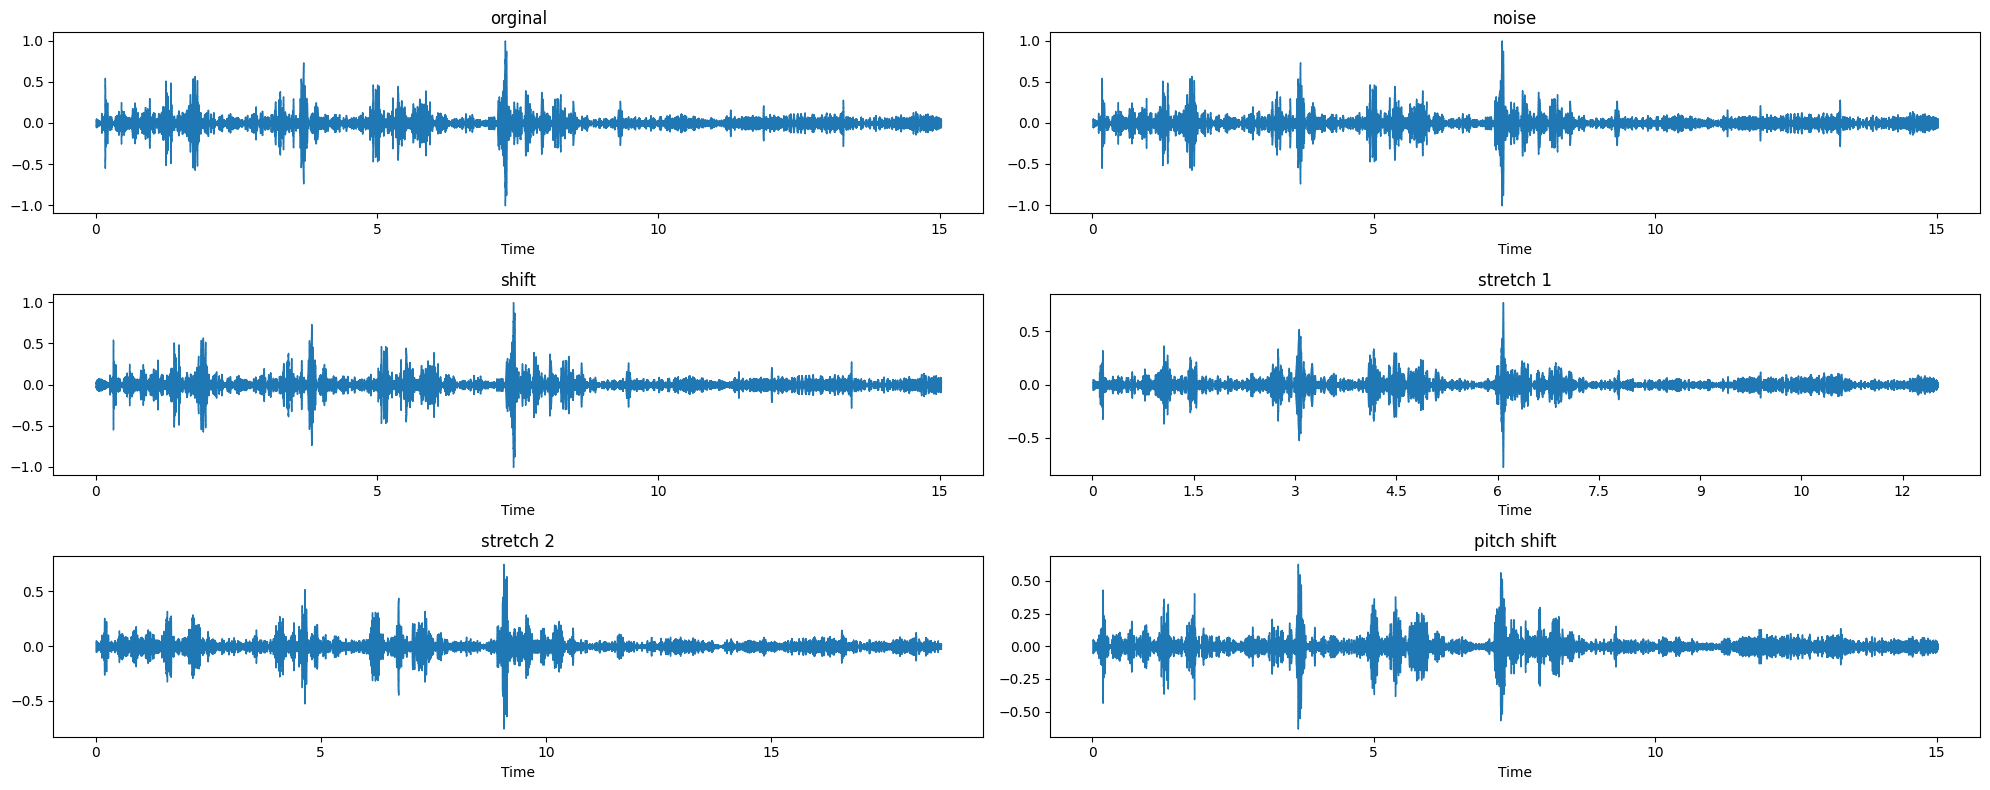

In [14]:
show_audio('../Lung/Lungs_Dataset/Respiratory_Sound_Database/audio_and_txt_files/104_1b1_Lr_sc_Litt3200.wav')

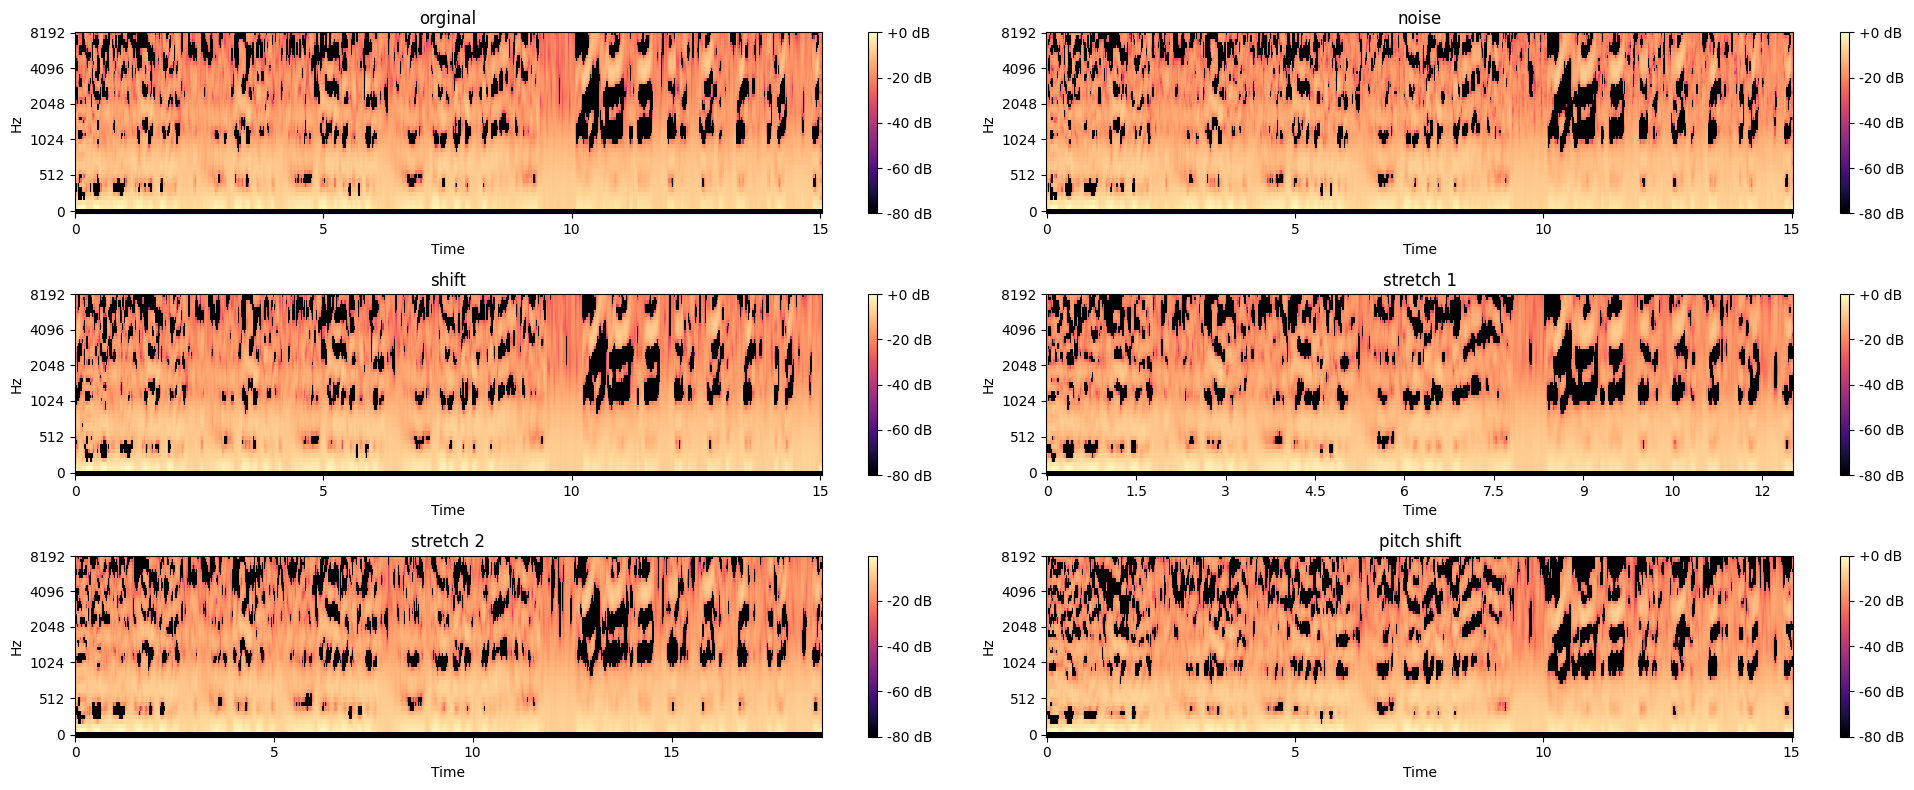

In [15]:
show_audio_features('../Lung/Lungs_Dataset/Respiratory_Sound_Database/audio_and_txt_files/104_1b1_Lr_sc_Litt3200.wav')

In [16]:
diagnosis_df['disease'].nunique()

3

In [17]:
diagnosis_df.head(20)

,pid,disease
0,101,Acute
1,102,Healthy
2,103,Chronic
3,104,Chronic
4,105,Acute
5,106,Chronic
6,107,Chronic
7,108,Healthy
8,109,Chronic
9,110,Chronic


In [20]:
def mfccs_feature_exteraction(dir_):
    '''
        Extract MFCC feature from the Sound data from the audio data. 
        Augmentation of sound data by adding Noise, streaching and shifting.
        50 features are extracted from each audio data and used to train the model. 
        
        Args: dir_: Input directory to the Sound input file.
        
        Returns:
            X_data: Array of features extracted from the sound file.
            y_data: Array of target Labels.
    '''
    X_=[]
    y_=[]
    
    Chronic=[]
    chronic_count=0
    
    data = diagnosis_df
    features = 52
    # i = 0
    for soundDir in (os.listdir(dir_)):
        # if soundDir[-3:]=='wav'and soundDir[:3]!='103':
        if soundDir[-3:]=='wav':
        # if soundDir[-3:]=='wav':
            p = list(data[data['pid']==int(soundDir[:3])]['disease'])[0]
            # i+=1
            # print(soundDir[:7])
            # print(soundDir[:-4])
            #---------------
            if (p=='Chronic'):
                if (soundDir[:7] in Chronic) and chronic_count<2:
                    data_x, sampling_rate = librosa.load(dir_+soundDir,res_type='kaiser_fast')
                    mfccs = np.mean(librosa.feature.mfcc(y=data_x, sr=sampling_rate, n_mfcc=features).T,axis=0)
                    Chronic.append(soundDir[:7])
                    chronic_count+=1
                    X_.append(mfccs)
                    y_.append(p)
                    
                if (soundDir[:7] not in Chronic):
                    data_x, sampling_rate = librosa.load(dir_+soundDir,res_type='kaiser_fast')
                    mfccs = np.mean(librosa.feature.mfcc(y=data_x, sr=sampling_rate, n_mfcc=features).T,axis=0)
                    Chronic.append(soundDir[:7])
                    chronic_count=0
                    X_.append(mfccs)
                    y_.append(p)
                
            elif (p=='Acute') or (p=='Healthy'):
                data_x, sampling_rate = librosa.load(dir_+soundDir,res_type='kaiser_fast')
                mfccs = np.mean(librosa.feature.mfcc(y=data_x, sr=sampling_rate, n_mfcc=features).T,axis=0)
                X_.append(mfccs)
                y_.append(p)
            
                data_noise = add_noise(data_x,0.001)
                mfccs_noise = np.mean(librosa.feature.mfcc(y=data_noise, sr=sampling_rate, n_mfcc=features).T,axis=0)
                X_.append(mfccs_noise)
                y_.append(p)

                data_shift = shift(data_x,1600)
                mfccs_shift = np.mean(librosa.feature.mfcc(y=data_shift, sr=sampling_rate, n_mfcc=features).T,axis=0)
                X_.append(mfccs_shift)
                y_.append(p)
                    
                data_stretch = stretch(data_x,1.2)
                mfccs_stretch = np.mean(librosa.feature.mfcc(y=data_stretch, sr=sampling_rate, n_mfcc=features).T,axis=0)
                X_.append(mfccs_stretch)
                y_.append(p)
                    
                data_stretch_2 = stretch(data_x,0.8)
                mfccs_stretch_2 = np.mean(librosa.feature.mfcc(y=data_stretch_2, sr=sampling_rate, n_mfcc=features).T,axis=0)
                X_.append(mfccs_stretch_2)
                y_.append(p)
                    
                data_pitch_shift = pitch_shift(data_x,3)
                mfccs_stretch = np.mean(librosa.feature.melspectrogram(y=data_pitch_shift, sr=sampling_rate, n_mels=features).T,axis=0)
                X_.append(mfccs_stretch)
                y_.append(p)
            # ---------------------       
            # elif(p=='Healthy'): 
            #     data_x, sampling_rate = librosa.load(dir_+soundDir,res_type='kaiser_fast')
            #     mfccs = np.mean(librosa.feature.mfcc(y=data_x, sr=sampling_rate, n_mfcc=features).T,axis=0)
            #     X_.append(mfccs)
            #     y_.append(p)
                
            #     data_noise = add_noise(data_x,0.001)
            #     mfccs_noise = np.mean(librosa.feature.mfcc(y=data_noise, sr=sampling_rate, n_mfcc=features).T,axis=0)
            #     X_.append(mfccs_noise)
            #     y_.append(p)

            #     data_shift = shift(data_x,1600)
            #     mfccs_shift = np.mean(librosa.feature.mfcc(y=data_shift, sr=sampling_rate, n_mfcc=features).T,axis=0)
            #     X_.append(mfccs_shift)
            #     y_.append(p)
                        
            #     data_stretch = stretch(data_x,1.2)
            #     mfccs_stretch = np.mean(librosa.feature.mfcc(y=data_stretch, sr=sampling_rate, n_mfcc=features).T,axis=0)
            #     X_.append(mfccs_stretch)
            #     y_.append(p)
                        
            #     data_stretch_2 = stretch(data_x,0.8)
            #     mfccs_stretch_2 = np.mean(librosa.feature.mfcc(y=data_stretch_2, sr=sampling_rate, n_mfcc=features).T,axis=0)
            #     X_.append(mfccs_stretch_2)
            #     y_.append(p)
                        
            #     data_pitch_shift = pitch_shift(data_x,3)
            #     mfccs_stretch = np.mean(librosa.feature.melspectrogram(y=data_pitch_shift, sr=sampling_rate, n_mels=features).T,axis=0)
            #     X_.append(mfccs_stretch)
            #     y_.append(p)
                    
    # print(p)        
    # print(i)            
    X_data = np.array(X_)
    y_data = np.array(y_)
    return X_data, y_data

In [21]:
# mfccs_feature_exteraction(audio_data)
x_mfccs, y = mfccs_feature_exteraction(audio_data)

In [22]:
def augmented_lables_count(lables):
    unique, counts = np.unique(lables, return_counts=True)
    data_count = dict(zip(unique, counts))

    data = data_count

    courses = list(data.keys())
    values = list(data.values())

    fig = plt.figure(figsize = (10, 5))

    # creating the bar plot
    plt.bar(courses, values, color =['orange','green','blue'],
            width = 0.4)

    plt.xlabel("Diseases")
    plt.ylabel("Count")
    plt.grid(axis = 'y',color = 'green', linestyle = '--', linewidth = 0.5)
    plt.title("Count of each disease")
    plt.show()

    print(data_count)

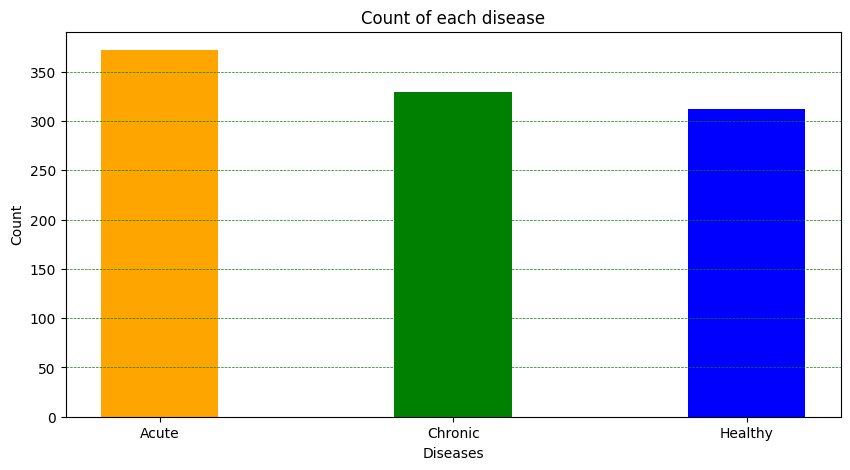

{'Acute': 372, 'Chronic': 329, 'Healthy': 312}


In [23]:
augmented_lables_count(y)
# {'Acute': 450, 'Chronic': 323, 'Healthy': 210}
# {'Acute': 450, 'Chronic': 323, 'Healthy': 222}
# {'Acute': 438, 'Chronic': 321, 'Healthy': 222}
# {'Acute': 372, 'Chronic': 321, 'Healthy': 222}
# {'Acute': 372, 'Chronic': 327, 'Healthy': 312}
# {'Acute': 372, 'Chronic': 329, 'Healthy': 312}

In [24]:
y_data_encode = y.reshape(y.shape[0],1)
y_data_encode = np.where(y_data_encode == 'Chronic',np.array([1,0,0]).reshape(1,3) , y_data_encode)
y_data_encode = np.where(y_data_encode == 'Acute',np.array([0,1,0]).reshape(1,3) , y_data_encode)
y_data_encode = np.where(y_data_encode == 'Healthy',np.array([0,0,1]).reshape(1,3) , y_data_encode)

Y_data = y_data_encode.astype('float64')

In [25]:
type(Y_data)

numpy.ndarray

In [26]:
mfccs_features = np.array(x_mfccs)
lables = np.array(Y_data)

mfccs_features.shape , lables.shape

((1013, 52), (1013, 3))

In [27]:
lables

array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       ...,
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.]])

In [ ]:
# mfcc_train, mfcc_val, lables_train, lables_val  = train_test_split(mfccs_features, lables, test_size=0.175, random_state=10)
# mfcc_train, mfcc_test, lables_train, lables_test = train_test_split(mfcc_train, lables_train, test_size=0.075, random_state=10)

# print (mfcc_train.shape, mfcc_val.shape, mfcc_test.shape)
# print (lables_train.shape, lables_val.shape, lables_test.shape)

(757, 52) (174, 52) (62, 52)
(757, 3) (174, 3) (62, 3)


In [28]:
# Step 1: Split the data into training and remaining (validation + testing)
mfcc_train_val, mfcc_test, lables_train_val, lables_test = train_test_split(mfccs_features, lables, test_size=0.10, random_state=10)
# Step 2: Further split the remaining data into validation and testing
# Calculate the ratio of validation to total remaining data (90% of original)
validation_ratio = 0.20 / 0.90  # Ratio of validation data to remaining data
mfcc_train, mfcc_val, lables_train, lables_val = train_test_split(mfcc_train_val, lables_train_val, test_size=validation_ratio, random_state=10)

# Print the shapes of the resulting datasets
print("Training Data:")
print("MFCC Train Shape:", mfcc_train.shape)
print("Labels Train Shape:", lables_train.shape)

print("\nValidation Data:")
print("MFCC Validation Shape:", mfcc_val.shape)
print("Labels Validation Shape:", lables_val.shape)

print("\nTesting Data:")
print("MFCC Test Shape:", mfcc_test.shape)
print("Labels Test Shape:", lables_test.shape)

Training Data:
MFCC Train Shape: (708, 52)
Labels Train Shape: (708, 3)

Validation Data:
MFCC Validation Shape: (203, 52)
Labels Validation Shape: (203, 3)

Testing Data:
MFCC Test Shape: (102, 52)
Labels Test Shape: (102, 3)


In [29]:
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  Args:
    history: TensorFlow model History object (see: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
#   plt.plot(epochs, loss, label='training_loss')
#   plt.plot(epochs, val_loss, label='val_loss')
#   plt.title('Loss')
#   plt.xlabel('Epochs')
#   plt.legend()
#   plt.grid()


  # Plot accuracy
  plt.figure()
  plt.grid()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend()

In [30]:
x_train_gru = np.expand_dims(mfcc_train,axis=1)
x_val_gru = np.expand_dims(mfcc_val,axis=1)
x_test_gru = np.expand_dims(mfcc_test,axis=1)

y_train_gru = np.expand_dims(lables_train,axis=1)
y_val_gru = np.expand_dims(lables_val,axis=1)
y_test_gru = np.expand_dims(lables_test,axis=1)

In [31]:
Input_Sample = Input(shape=(1,52))

model_conv = Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu')(Input_Sample)
model_conv = MaxPooling1D(pool_size=2, strides = 2, padding = 'same')(model_conv)
model_conv = BatchNormalization()(model_conv)

model_conv = Conv1D(512, kernel_size=5, strides=1, padding='same', activation='relu')(model_conv)
model_conv = MaxPooling1D(pool_size=2, strides = 2, padding = 'same')(model_conv)
model_conv = BatchNormalization()(model_conv)

model_2_1 = GRU(32,return_sequences=True,activation='tanh',go_backwards=True)(model_conv)
model_2 = GRU(128,return_sequences=True, activation='tanh',go_backwards=True)(model_2_1)

model_3 = GRU(64,return_sequences=True,activation='tanh',go_backwards=True)(model_conv)
model_3 = GRU(128,return_sequences=True, activation='tanh',go_backwards=True)(model_3)

model_x = GRU(64,return_sequences=True,activation='tanh',go_backwards=True)(model_conv)
model_x = GRU(128,return_sequences=True, activation='tanh',go_backwards=True)(model_x)

model_add_1 = add([model_3,model_2,model_x])

model_5 = GRU(128,return_sequences=True,activation='tanh',go_backwards=True)(model_add_1)
model_5 = GRU(32,return_sequences=True, activation='tanh',go_backwards=True)(model_5)

model_6 = GRU(64,return_sequences=True,activation='tanh',go_backwards=True)(model_add_1)
model_6 = GRU(32,return_sequences=True, activation='tanh',go_backwards=True)(model_6)

model_add_2 = add([model_5,model_6,model_2_1])


model_7 = Dense(32, activation=None)(model_add_2)
model_7 = LeakyReLU()(model_7)
model_7 = Dense(128, activation=None)(model_7)
model_7 = LeakyReLU()(model_7)

model_9 = Dense(64, activation=None)(model_add_2)
model_9 = LeakyReLU()(model_9)
model_9 = Dense(128, activation=None)(model_9)
model_9 = LeakyReLU()(model_9)

model_add_3 = add([model_7,model_9])

model_10 = Dense(64, activation=None)(model_add_3)
model_10 = LeakyReLU()(model_10)

model_10 = Dense(32, activation=None)(model_10)
model_10 = LeakyReLU()(model_10)

model_10 = Dense(3, activation="softmax")(model_10)

gru_model = Model(inputs=Input_Sample, outputs = model_10)

gru_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 1, 52)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 1, 256)    │     66,816 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 1, 256)    │          0 │ conv1d[0][0]      │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 1, 256)    │      1,024 │ max_pooling1d[0]… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 1, 512)    │    655,872 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 1, 512)    │          0 │ conv1d_1[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1, 512)    │      2,048 │ max_pooling1d_1[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_2 (GRU)         │ (None, 1, 64)     │    110,976 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru (GRU)           │ (None, 1, 32)     │     52,416 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_4 (GRU)         │ (None, 1, 64)     │    110,976 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_3 (GRU)         │ (None, 1, 128)    │     74,496 │ gru_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_1 (GRU)         │ (None, 1, 128)    │     62,208 │ gru[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_5 (GRU)         │ (None, 1, 128)    │     74,496 │ gru_4[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 1, 128)    │          0 │ gru_3[0][0],      │
│                     │                   │            │ gru_1[0][0],      │
│                     │                   │            │ gru_5[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_6 (GRU)         │ (None, 1, 128)    │     99,072 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_8 (GRU)         │ (None, 1, 64)     │     37,248 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_7 (GRU)         │ (None, 1, 32)     │     15,552 │ gru_6[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_9 (GRU)         │ (None, 1, 32)     │      9,408 │ gru_8[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 1, 32)     │          0 │ gru_7[0][0],      │
│                     │                   │            │ gru_9[0][0],      │
│                     │                   │            │ gru[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1, 32)     │      1,056 │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 1,398,755 (5.34 MB)

 Trainable params: 1,397,219 (5.33 MB)

 Non-trainable params: 1,536 (6.00 KB)

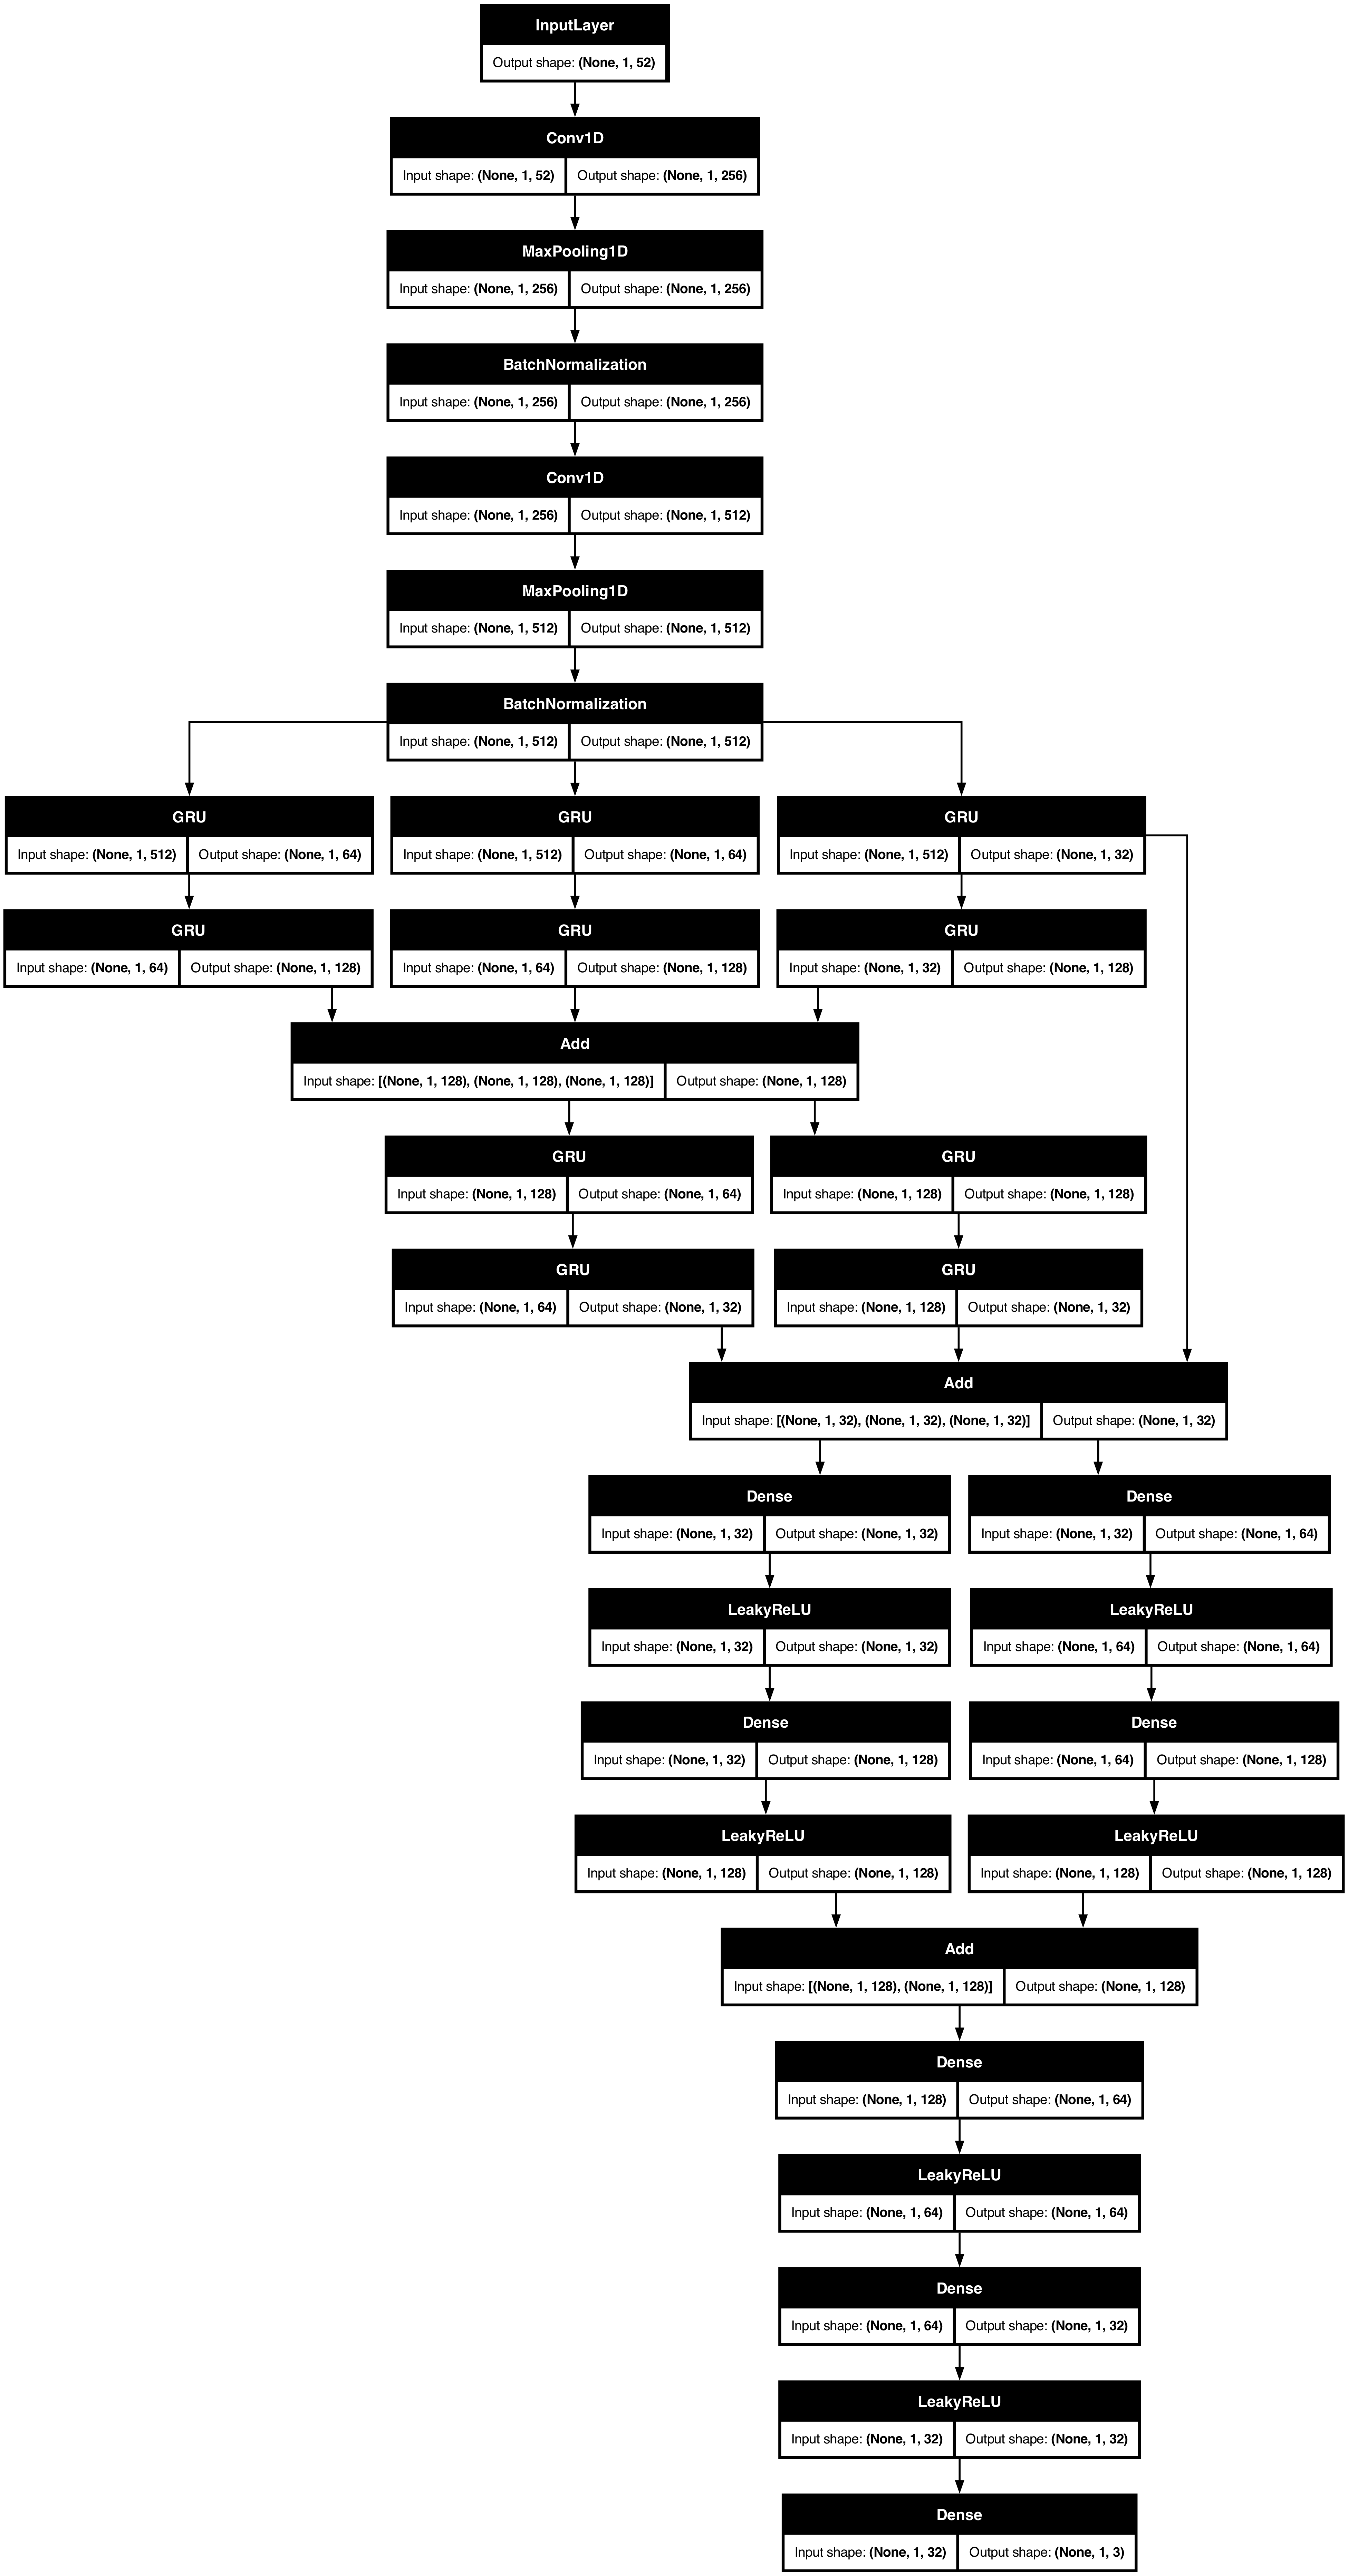

In [32]:
tf.keras.utils.plot_model(gru_model, "gru_model.png", show_shapes=True)

In [35]:
# optimiser = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
gru_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# cb = [EarlyStopping(patience=300, monitor='accuracy', mode='max', restore_best_weights=True),
#       # ModelCheckpoint("./diagnosis_GRU_CNN_1.h5", save_best_only=True)]
#       ModelCheckpoint("./diagnosis_GRU_CNN_3.h5", save_best_only=True)]
cb = [
    tf.keras.callbacks.EarlyStopping(patience=300, monitor='accuracy', mode='max', restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint("./diagnosis_GRU_CNN_5.keras", save_best_only=True)
]

In [36]:
history = gru_model.fit(x_train_gru, y_train_gru, batch_size=10, epochs=800, validation_data=(x_val_gru, y_val_gru), callbacks = cb)

Epoch 1/800
71/71 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.4741 - loss: 1.0084 - val_accuracy: 0.4926 - val_loss: 0.9773
Epoch 2/800
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6418 - loss: 0.7359 - val_accuracy: 0.6010 - val_loss: 0.8355
Epoch 3/800
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7158 - loss: 0.6715 - val_accuracy: 0.5862 - val_loss: 0.8509
Epoch 4/800
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7367 - loss: 0.6316 - val_accuracy: 0.7143 - val_loss: 0.6408
Epoch 5/800
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7663 - loss: 0.5557 - val_accuracy: 0.7192 - val_loss: 0.5907
Epoch 6/800
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7464 - loss: 0.5474 - val_accuracy: 0.7192 - val_loss: 0.5923
Epoch 7/800
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7528 - loss: 0.5293 - val_accuracy: 0.7094 - val_loss: 0.5702
Epoch 8/800
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7610 - loss: 0.5565 - val_accuracy: 0

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9754 - loss: 0.0529


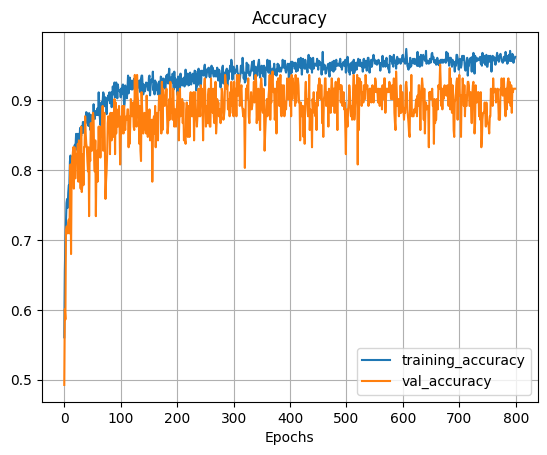

In [37]:
gru_model.evaluate(x_train_gru, y_train_gru)

plot_loss_curves(history)
#model 2:  24/24 [==============================] - 0s 4ms/step - loss: 0.0719 - accuracy: 0.9666
#model 3:  24/24 [==============================] - 0s 3ms/step - loss: 0.0447 - accuracy: 0.9775
#model 4:  23/23 [==============================] - 0s 3ms/step - loss: 0.0584 - accuracy: 0.9661
#model 5:  23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9754 - loss: 0.0529

In [38]:
# Save the model in the native Keras format
gru_model.save('diagnosis_GRU_CNN_5.keras')
# gru_model.save("./diagnosis_model3.h5")

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 276ms/step


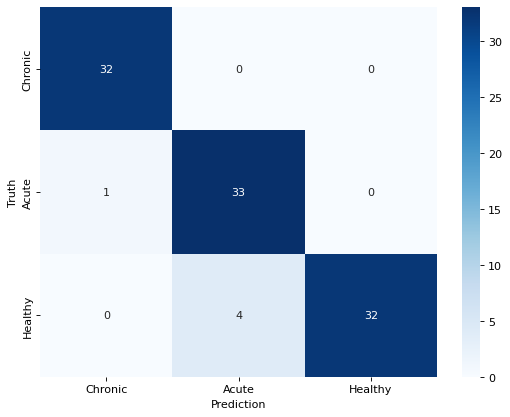

In [39]:
classes = ['Chronic','Acute','Healthy']

preds = gru_model.predict(x_test_gru)
classpreds = [np.argmax(t) for t in preds ]
y_testclass = [np.argmax(t) for t in y_test_gru]
cm = confusion_matrix(y_testclass, classpreds)

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
ax = sns.heatmap(cm, cmap='Blues', annot=True, fmt='d', xticklabels=classes, yticklabels=classes)

plt.title('')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)

In [40]:
print(classification_report(y_testclass, classpreds, target_names=classes))

              precision    recall  f1-score   support

     Chronic       0.97      1.00      0.98        32
       Acute       0.89      0.97      0.93        34
     Healthy       1.00      0.89      0.94        36

    accuracy                           0.95       102
   macro avg       0.95      0.95      0.95       102
weighted avg       0.95      0.95      0.95       102



In [41]:
def gru_diagnosis_prediction(test_audio):
    data_x, sampling_rate = librosa.load(test_audio)
    data_x = stretch (data_x,1.2)

    features = np.mean(librosa.feature.mfcc(y=data_x, sr=sampling_rate, n_mfcc=52).T,axis = 0)

    features = features.reshape(1,52)

    test_pred = gru_model.predict(np.expand_dims(features, axis = 1))
    classpreds = classes[np.argmax(test_pred[0], axis=1)[0]]
    confidence = test_pred.T[test_pred[0].mean(axis=0).argmax()].mean()

    print (classpreds , confidence)

In [42]:
gru_diagnosis_prediction('../Lung/Lungs_Dataset/Respiratory_Sound_Database/audio_and_txt_files/224_1b1_Tc_sc_Meditron.wav')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Healthy 0.99754936


In [43]:
gru_diagnosis_prediction('../Lung/Lungs_Dataset/Respiratory_Sound_Database/audio_and_txt_files/108_1b1_Al_sc_Meditron.wav')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Healthy 0.9998093


In [44]:
gru_diagnosis_prediction('../Lung/Lungs_Dataset/Respiratory_Sound_Database/audio_and_txt_files/182_1b1_Tc_sc_Meditron.wav')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Healthy 0.9089384


In [45]:
gru_diagnosis_prediction('../Lung/Lungs_Dataset/Respiratory_Sound_Database/audio_and_txt_files/223_1b1_Al_sc_Meditron.wav')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Chronic 0.5160049


In [46]:
gru_diagnosis_prediction('../Lung/Lungs_Dataset/Respiratory_Sound_Database/audio_and_txt_files/226_1b1_Pl_sc_LittC2SE.wav')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Acute 0.99998343


In [47]:
gru_model.history

In [48]:
print(history.history.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


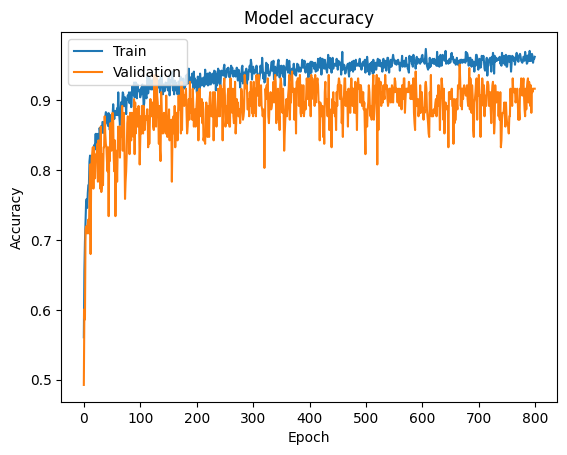

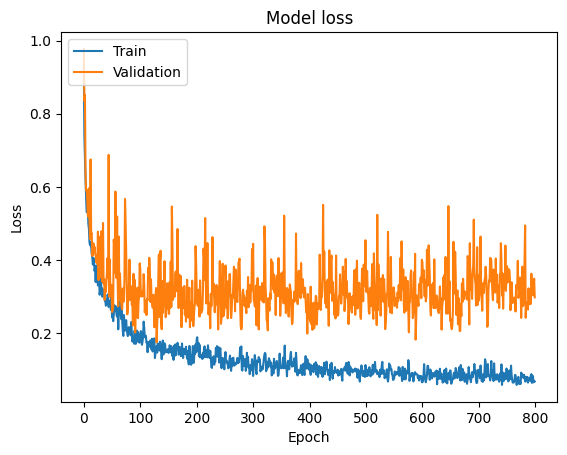

In [49]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [50]:
import pickle
with open('model5_training_history.pkl', 'wb') as file:
    pickle.dump(history.history, file)

In [51]:
import pickle
import matplotlib.pyplot as plt

# Load the saved history data from the file
with open('model5_training_history.pkl', 'rb') as file:
    loaded_history = pickle.load(file)

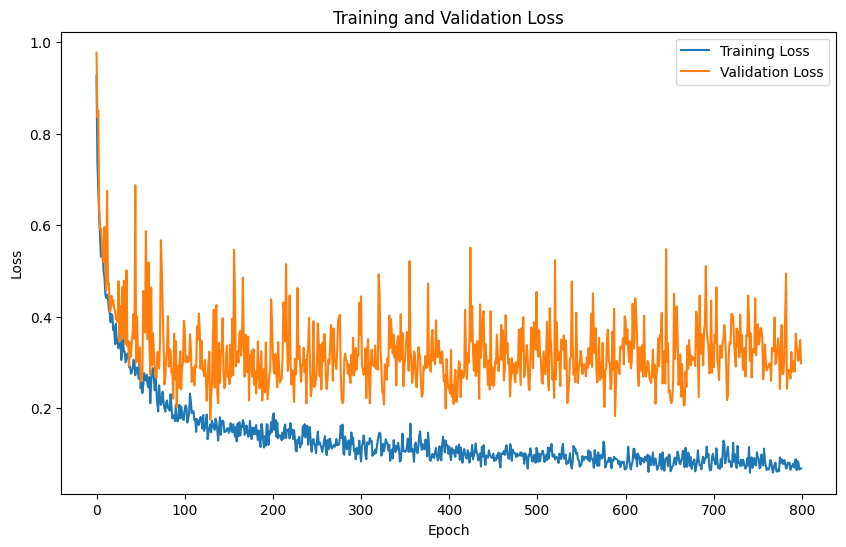

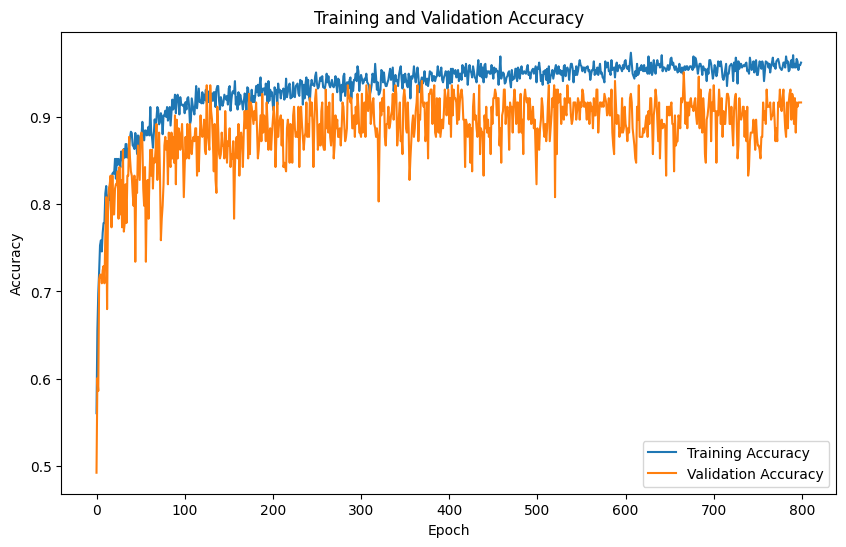

In [52]:
#  Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(loaded_history['loss'], label='Training Loss')
plt.plot(loaded_history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(loaded_history['accuracy'], label='Training Accuracy')
plt.plot(loaded_history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [55]:
df = pd.DataFrame()

In [56]:
df['accuracy']=history.history['accuracy']

In [57]:
df['accuracy']

0      0.560734
1      0.655367
2      0.697740
3      0.723164
4      0.752825
         ...   
795    0.963277
796    0.953390
797    0.959040
798    0.959040
799    0.961864
Name: accuracy, Length: 800, dtype: float64

In [59]:
df['val_accuracy'] = history.history['val_accuracy']

In [60]:
df

,accuracy,val_accuracy
0,0.560734,0.492611
1,0.655367,0.600985
2,0.697740,0.586207
3,0.723164,0.714286
4,0.752825,0.719212
...,...,...
795,0.963277,0.911330
796,0.953390,0.916256
797,0.959040,0.916256
798,0.959040,0.916256


In [62]:
df.to_csv('./model5_accuracy_epoch_values.csv',index=None)